In [2]:
import pybamm
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot

In [7]:
# Define the model
def battery_model(parameters):
    # Creating a DFN model
    model = pybamm.lithium_ion.DFN()
    # 创建实验
    experiment = pybamm.Experiment(
        ["Rest for 901 s",
            "Discharge at 0.96 A for 147 s",
            "Rest for 361 s",
            "Discharge at 0.96 A for 134 s"
        ]
    )
    # Loading the default parameter set
    param = model.default_parameter_values
    param["Separator porosity"] = 0.5
    # Updating parameters
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        # "Negative electrode diffusivity [m2.s-1]": parameters[17],
        # "Positive electrode diffusivity [m2.s-1]": parameters[18],
        # "Electrolyte diffusivity [m2.s-1]": parameters[19],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20],
        # "Separator porosity": parameters[21]
    })
    
    # Creating a Casadi solver and setting options
    solver = pybamm.CasadiSolver(
        mode="safe", 
        atol=1e-1, 
        rtol=1e-1, 
        dt_max=0.01,  # Decrease the maximum time step
        max_step_decrease_count=2000  # Increase in step size decrease in frequency
    )
    
    # Creating a Simulation
    simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
    solution = simulation.solve(calc_esoh=False)
    voltage = solution["Terminal voltage [V]"].entries
    
    # Returns the voltage at the end of the simulation
    return voltage[19]

In [8]:

# Defining the parameter space
problem = {
    'num_vars': 21,
    'names': ['Negative electrode thickness [m]', 
              'Positive electrode thickness [m]', 
              'Separator thickness [m]',
              'Negative electrode active material volume fraction',
              'Positive electrode active material volume fraction',
              'Negative particle radius [m]',
              'Positive particle radius [m]',
              'Initial concentration in electrolyte [mol.m-3]',
              'Negative electrode conductivity [S.m-1]',
              'Positive electrode conductivity [S.m-1]',
              'Negative electrode Bruggeman coefficient (electrode)',
              'Positive electrode Bruggeman coefficient (electrode)',
              'Separator Bruggeman coefficient (electrolyte)',
              'Maximum concentration in negative electrode [mol.m-3]',
              'Maximum concentration in positive electrode [mol.m-3]',
              'Electrode height [m]',
              'Electrode width [m]',
              'Negative electrode double-layer capacity [F.m-2]',
              'Positive electrode double-layer capacity [F.m-2]',
              'Negative electrode porosity',
              'Positive electrode porosity'
              ],
    'bounds': [[9e-5, 11e-5],  # Narrowing down the parameters 0.0001
               [9e-5, 11e-5],  #0.0001
               [1e-5, 3e-5],  #2.5e-05
               [0.6, 0.7],      #0.6
               [0.35, 0.5],     #0.5
               [1e-5, 2e-5],    #1e-05
               [1e-5, 2e-5],    #1e-05
               [1e3, 1.2e3],    #1000
               [1e2, 2e2],      #100
               [9, 15],        #10
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [1.3, 1.7],      #1.5
               [2.3e4, 3.4e4],  #24983.2619938437
               [5.0e4, 5.3e4],  #51217.9257309275
               [0.1, 0.15],     #0.137     
               [0.2, 0.25],     #0.207
               [0.1, 1],        #0.2
               [0.1, 1],        #0.2
               [0.26, 0.5],     #0.3
               [0.27, 0.45]     #0.3
               ]       
}

In [9]:
# Generate a sample
param_values = saltelli.sample(problem, 128)  # Further reduction of sample size to improve debugging efficiency

In [10]:
# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

In [11]:
# Perform sensitivity analyses
Si = sobol.analyze(problem, Y_valid, print_to_console=True)

                                                              ST       ST_conf
Negative electrode thickness [m]                    2.441931e-04  1.533101e-04
Positive electrode thickness [m]                    2.504449e-02  7.620382e-03
Separator thickness [m]                             6.169674e-04  1.792312e-04
Negative electrode active material volume fraction  4.311189e-04  3.625994e-04
Positive electrode active material volume fraction  8.638594e-02  2.213851e-02
Negative particle radius [m]                        4.716675e-03  2.613021e-03
Positive particle radius [m]                        1.547480e-01  3.749678e-02
Initial concentration in electrolyte [mol.m-3]      1.287083e-04  4.045179e-05
Negative electrode conductivity [S.m-1]             1.011245e-09  4.685973e-10
Positive electrode conductivity [S.m-1]             3.157286e-10  1.353538e-10
Negative electrode Bruggeman coefficient (elect...  6.805071e-11  3.683371e-11
Positive electrode Bruggeman coefficient (elect...  

In [12]:
categories = [r'$L^{-}$',
              r'$L^{+}$',
              r'$L^{s}$',
              r'$\varepsilon_s^{-}$',
              r'$\varepsilon_s^{+}$',
              r'$R_p^{-}$',
              r'$R_p^{+}$',
              r'$c_{e, 0}$',
              r'$\sigma_s^{-}$',
              r'$\sigma_s^{+}$',
              r'$b^{-}$',
              r'$b^{+}$',
              r'$b^{s}$',
              r'$c_{s, \text { max }}^{-}$',
              r'$c_{s, \text { max }}^{+}$',
              r'$L_{E}$',
              r'$W_{E}$',
              r'$C_{dl}^{-}$',
              r'$C_{dl}^{+}$',
              r'$\varepsilon_e^{-}$',
              r'$\varepsilon_e^{+}$'
              ]

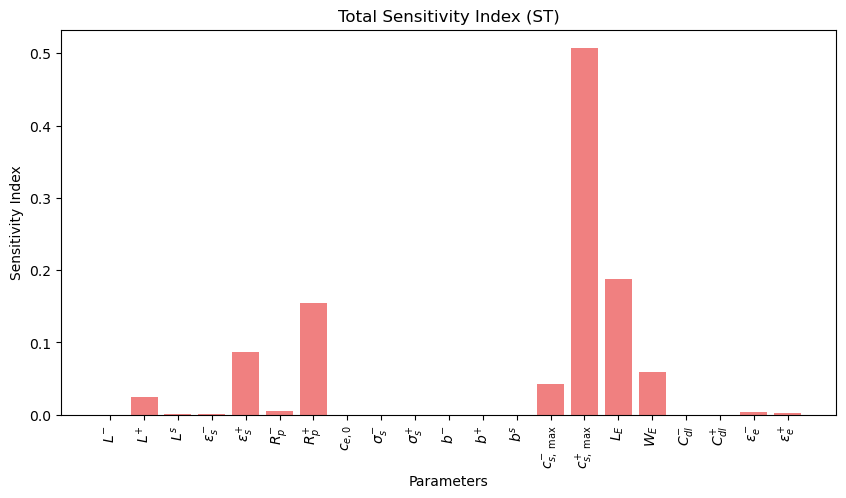

In [13]:
params = categories
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()